# Facenet

This notebook contains 2 stages: preprocessing and embedding. The proccesed faces is stored in folder `NumpyFace` and the embbedings face is stored in folder `EmbeddingFace`. The embedding face is used to train SVMs model in `facenet_keras_recognition.ipynb`. 

❗`Note:`These stages are slow and require dataset. Also, each dataset need a unique preprocessing method. 

"I will use the pre-trained Keras FaceNet model provided by Hiroki Taniai in this tutorial. It was trained on MS-Celeb-1M dataset and expects input images to be color, to have their pixel values whitened (standardized across all three channels), and to have a square shape of 160×160 pixels."

In [5]:
%cd "../data/"
!ls
NUMPYFACEFOLDER = "../NumpyFace/"
EMBEDDINGFACEFOLDER = "../EmbeddingFace/"
MODELFOLDER = "../model/"

C:\Users\trihu\Documents\GitHub\FaceNet_MTCNN\data


'ls' is not recognized as an internal or external command,
operable program or batch file.


We will use the implementation provided by Iván de Paz Centeno in the ipazc/mtcnn project. This can also be installed via pip as follows:

In [19]:
from mtcnn import MTCNN
##################### NUMPY ####################
from numpy import newaxis
from numpy import asarray
from numpy import savez_compressed
from numpy import load
from numpy import expand_dims
import numpy as np

##################### SKLEARN ####################

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

from keras.models import load_model

from random import choice

##################### IMAGE ####################
import cv2
from matplotlib import pyplot
from PIL import Image
##################### FILE #####################
from os.path import isdir
from os import listdir
import os

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Extract multiple images

In [15]:
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

## 5-celebrity-faces-datase

```
5-celebrity-faces-dataset
├── train
│   ├── ben_afflek
│   ├── elton_john
│   ├── jerry_seinfeld
│   ├── madonna
│   └── mindy_kaling
└── val
    ├── ben_afflek
    ├── elton_john
    ├── jerry_seinfeld
    ├── madonna
    └── mindy_kaling
```

In [10]:
# extract a single face from a given photograph
def extract_face_png(filename, required_size=(160, 160)):
	"""	Extract file format "png", "jpeg",... with MTCNN """
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

def load_faces(directory):
	""" Load images and extract faces for all images in a directory """
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face_png(path)
		# store
		faces.append(face)
	return faces


1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


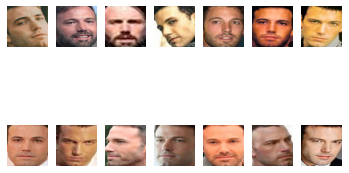

In [ ]:
# demonstrate face detection on 5 Celebrity Faces Dataset
# specify folder to plot
folder = '5-celebrity-faces-dataset/train/ben_afflek/'
i = 1
# enumerate files
for filename in listdir(folder):
	# path
	path = folder + filename
	# get face
	face = extract_face_png(path)
	print(i, face.shape)
	# plot
	pyplot.subplot(2, 7, i)
	pyplot.axis('off')
	pyplot.imshow(face)
	i += 1
pyplot.show()

A figure is created containing the faces detected in the Ben Affleck directory.



In [ ]:
# load train dataset
trainX, trainy = load_dataset('5-celebrity-faces-dataset/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('5-celebrity-faces-dataset/val/')
print(testX.shape, testy.shape)
# save arrays to one file in compressed format

savez_compressed(NUMPYFACEFOLDER + '5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 14 examples for class: ben_afflek
>loaded 17 examples for class: elton_john
>loaded 21 examples for class: jerry_seinfeld
>loaded 19 examples for class: madonna
>loaded 22 examples for class: mindy_kaling
(93, 160, 160, 3) (93,)
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: jerry_seinfeld
>loaded 5 examples for class: madonna
>loaded 5 examples for class: mindy_kaling
(25, 160, 160, 3) (25,)


In [ ]:
data = load(NUMPYFACEFOLDER + '5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


## AT&T dataset

```
AT&T
├── s0
├── s1
├── s2
├── s3
├── ...
└── s40
```

In [ ]:
# extract a single face from a given photograph
def extract_face_pgm(filename, required_size=(160, 160)):
	#In AT&T face dataset, the faces are cropped in adavanced, thus I do not use MTCNN
	img = cv2.imread(filename,-1) 
	img = cv2.resize(img, required_size)
	img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
	face = asarray(img)
	return face

# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face_pgm(path)
		# store
		faces.append(face)
	return faces

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)


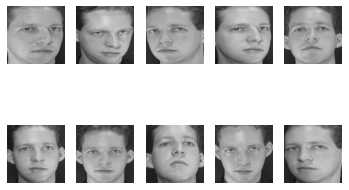

In [ ]:
folder = 'AT&T/s1/'
i = 1
# enumerate files
for filename in listdir(folder):
	# path
	path = folder + filename
	# get face
	face = extract_face_pgm(path)
	print(i, face.shape)
	# plot
	pyplot.subplot(2, 5, i)
	pyplot.axis('off')
	pyplot.imshow(face)
	i += 1
pyplot.show()

In [ ]:
# load train dataset
from sklearn.model_selection import train_test_split
X, y = load_dataset('AT&T/')
trainX, testX, trainy, testy = train_test_split(X, y)
print(trainX.shape, trainy.shape, testX.shape, testy.shape)
savez_compressed(NUMPYFACEFOLDER + 'ATT.npz', trainX, trainy, testX, testy)

>loaded 10 examples for class: s1
>loaded 10 examples for class: s10
>loaded 10 examples for class: s11
>loaded 10 examples for class: s12
>loaded 10 examples for class: s13
>loaded 10 examples for class: s14
>loaded 10 examples for class: s15
>loaded 10 examples for class: s16
>loaded 10 examples for class: s17
>loaded 10 examples for class: s18
>loaded 10 examples for class: s19
>loaded 10 examples for class: s2
>loaded 10 examples for class: s20
>loaded 10 examples for class: s21
>loaded 10 examples for class: s22
>loaded 10 examples for class: s23
>loaded 10 examples for class: s24
>loaded 10 examples for class: s25
>loaded 10 examples for class: s26
>loaded 10 examples for class: s27
>loaded 10 examples for class: s28
>loaded 10 examples for class: s29
>loaded 10 examples for class: s3
>loaded 10 examples for class: s30
>loaded 10 examples for class: s31
>loaded 10 examples for class: s32
>loaded 10 examples for class: s33
>loaded 10 examples for class: s34
>loaded 10 examples for

In [ ]:
data = load(NUMPYFACEFOLDER + 'ATT.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (300, 160, 160, 3) (300,) (100, 160, 160, 3) (100,)


## YALE

```
YALE
├── subject01.normal
├── subject01.happy
├── ...
├── subject15.sad
└── Readme.txt 
```

In [16]:
def convert_to_gif(dir):
  """Fixing the file extensions to GIF format"""
  files = os.listdir(dir)[1:]
  for i, img in enumerate(files):
    if 'Readme' in img: continue
    if 'gif' not in img:
      # print("original name: ", img)
      new_ext_name = "_".join(img.split(".")) + ".gif" # (or .jpg , .png, etc).
      # print("new name: ",  new_ext_name)
      os.rename(os.path.join(dir, img), os.path.join(dir, new_ext_name))

YALE_DIR = "yalefaces/"
convert_to_gif(YALE_DIR)

# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face_png(path)
		# store
		faces.append(face)
	return faces

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)


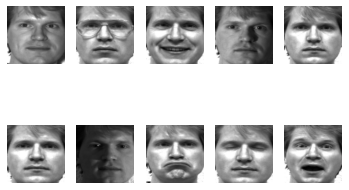

In [20]:

folder = 'yalefaces/'
i = 1
# enumerate files
for filename in listdir(folder):
  if i==11 : break
  if "Readme" in filename: continue
  else:
    # path
    path = folder + filename
    # get face
    face = extract_face_png(path)
    print(i, face.shape)
    # plot
    pyplot.subplot(2, 5, i)
    pyplot.axis('off')
    pyplot.imshow(face)
    i += 1
pyplot.show()

In [21]:
def load_dataset_YALE(directory):
  X, y = list(), list()
	# enumerate folders, on per class
  for i, image in enumerate(listdir(directory)):
    label = image[7:9]
    if "Readme" in image: continue
    path = directory + image 
		# load all faces in the subdirectory
    face = extract_face_png(path)
		# summarize progress
    if (i-10)/11 == int(label):
      print('>loaded %d examples ' % i+1)
		# store
    X.append(face)
    y.append(label)
    
  return asarray(X), asarray(y)
X, y = load_dataset_YALE('yalefaces/')
print(X.shape, y.shape)

(165, 160, 160, 3) (165,)


In [ ]:
# load train dataset
from sklearn.model_selection import train_test_split
X, y = load_dataset_YALE('yalefaces/')
print(X.shape, y.shape)
trainX, testX, trainy, testy = train_test_split(X, y)
print(trainX.shape, trainy.shape, testX.shape, testy.shape)
savez_compressed(NUMPYFACEFOLDER + 'yalefaces.npz', trainX, trainy, testX, testy)

(123, 160, 160, 3) (123,) (42, 160, 160, 3) (42,)


In [ ]:
data = load(NUMPYFACEFOLDER + 'yalefaces.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (123, 160, 160, 3) (123,) (42, 160, 160, 3) (42,)


## Extended Yale Database B

```
Extended Yale Database B
├── YaleB11
├── YaleB12
├── YaleB13
├── ...
└── YaleB39
    ├── yaleB39_P08A+130E+20.pgm
    ├── yaleB39_P08A+120E+00.pgm
    ├── ...
    ├── yaleB39_P08.info
    └── ...
```

In [ ]:
def extract_face_pgm_with_location(pixels, x1, x2, y1, y2, required_size = (160, 160)):
	if x1 is not None:
		face = pixels[y1:y2, x1:x2]
		image = Image.fromarray(face)
		image = image.resize(required_size)
		face_array = asarray(image)
		return face_array
	else: 
		return None

def get_pixels(filename):
	img = cv2.imread(filename,-1) 
	img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
	pixels = asarray(img)
	return pixels

def extract_location_face_pgm(filename):
	pixels = get_pixels(filename)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	if len(results) != 0:
		x1, y1, width, height = results[0]['box']
		x1, y1 = abs(x1), abs(y1)
		x2, y2 = x1 + width, y1 + height
		# extract the face
		return x1, x2, y1, y2
	else: 
		print("Unsuccessful cropped at file %s" % filename)
		return None, None, None, None

In [ ]:
# extract a single face from a given photograph
def read_face_pgm(filename, required_size=(160, 160)):
	# The AT&T dataset is aligned in advance.
	img = cv2.imread(filename,-1) 
	# img = cv2.resize(img, required_size)
	img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
	face = asarray(img)
	return face

Unsuccessful cropped at file ExtendedYaleB/yaleB23/yaleB23_P00A+000E+90.pgm
1
2
3
4
5


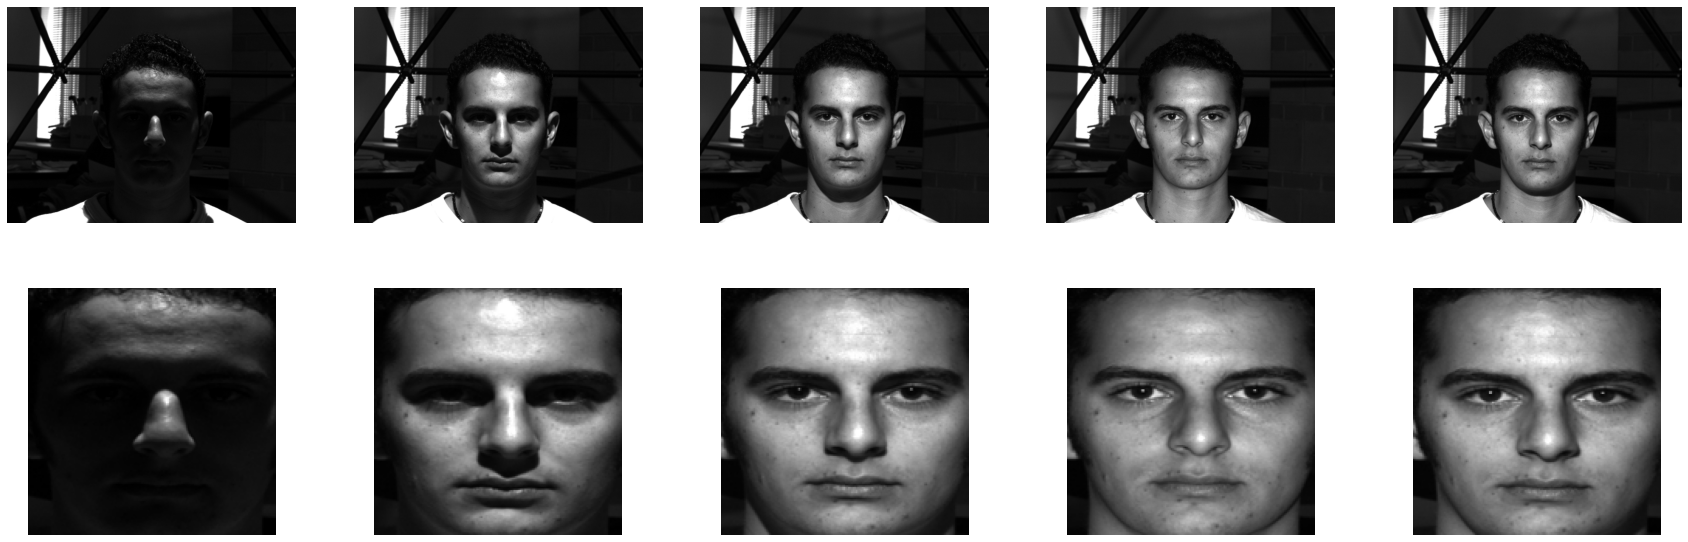

In [ ]:
folder = 'ExtendedYaleB/yaleB23/'
i = 1

# extract location of 1 image and use the location for the others
x1, x2, y1, y2 = None, None, None, None
for filename in listdir(folder):
  if 'info' in filename: continue
  path = folder + filename
  x1, x2, y1, y2 = extract_location_face_pgm(path)
  if x1 is not None: 
    break

# enumerate files
pyplot.figure(figsize=(30,10))
for filename in listdir(folder):
  if i == 6: break
  if 'info' in filename: continue
  path = folder + filename
  face = read_face_pgm(path)
  pyplot.subplot(2,5, i)
  pyplot.axis('off')
  pyplot.imshow(face)
  i += 1

for filename in listdir(folder):
  if i == 11: break
  if 'info' in filename: continue
  path = folder + filename
  pixels = get_pixels(path)
  face = extract_face_pgm_with_location(pixels, x1, x2, y1, y2)
  pyplot.subplot(2,5, i)
  pyplot.axis('off')
  pyplot.imshow(face)
  i += 1
pyplot.savefig('YaleB+', format="png", bbox_inches='tight')
pyplot.show()


In [ ]:
def load_faces_YALE_B_plus(directory):
  faces = list()
  x1, x2, y1, y2 = None, None, None, None

  # Loop to avoid a too dark face. MTCNN cannot detect it
  for filename in listdir(directory): 
    if 'info' in filename: continue
    path = directory + filename
    x1, x2, y1, y2 = extract_location_face_pgm(path)
    if x1 is not None: # MTCNN can crop face => stop => use the same crop 
      break            # location (x1, x2, y1, y2) for other images
      
  # Crop images with location (x1, x2, y1, y2)    
  for filename in listdir(directory): 
    if 'info' in filename: continue
    path = directory + filename
    pixels = get_pixels(path)
    # get face
    face = extract_face_pgm_with_location(pixels, x1, x2, y1, y2)
    # store
    faces.append(face)
  return faces

In [ ]:
def load_dataset_3_account(directory, idx):
  # Run on 3 GG accounts
  divided_dir= []
  if idx == 0: 
    divided_dir = listdir(directory)[0:9]
  elif idx == 1:
    divided_dir = listdir(directory)[9:18]
  else:
    divided_dir = listdir(directory)[18:]

  X, y = list(), list()
  # enumerate folders, on per class
  for subdir in divided_dir:
    # path
    path = directory + subdir + '/'
    # skip any files that might be in the dir
    if not isdir(path):
      continue
    # load all faces in the subdirectory
    faces = load_faces(path)
    # create labels
    labels = [subdir for _ in range(len(faces))]
    # summarize progress
    print('>loaded %d examples for class: %s' % (len(faces), subdir))
    # store
    X.extend(faces)
    y.extend(labels)
  return asarray(X), asarray(y)

In [ ]:
from sklearn.model_selection import train_test_split
X, y = load_dataset_3_account('ExtendedYaleB/', 0)
trainX, testX, trainy, testy = train_test_split(X, y)
print(trainX.shape, trainy.shape, testX.shape, testy.shape)
savez_compressed(NUMPYFACEFOLDER + 'extended_yale_face_B_cropped0.npz', trainX, trainy, testX, testy)

In [ ]:
trainX, trainy, testX, testy = [], [], [], []
for i in range(3):
	data = load(f'{NUMPYFACEFOLDER}extended_yale_face_B_cropped{i}.npz')
	trainX.extend(data['arr_0'])
	trainy.extend(data['arr_1'])
	testX.extend(data['arr_2'])
	testy.extend(data['arr_3'])
trainX, trainy, testX, testy = asarray(trainX), asarray(trainy), asarray(testX), asarray(testy)
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (12283, 160, 160, 3) (12283,) (4097, 160, 160, 3) (4097,)


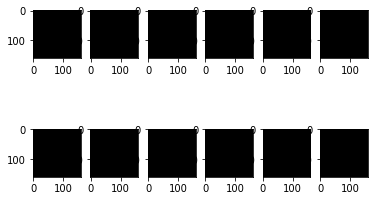

In [ ]:
train_dark_idx = [1121,1262,1298,1497,3522]
test_dark_idx = [39, 292, 490, 1128, 1151, 1227, 1258]
i = 1
for idx in train_dark_idx:
  pyplot.subplot(2,6,i)
  pyplot.imshow(trainX[idx])
  i=i+1

for idx in test_dark_idx:
  pyplot.subplot(2,6,i)
  pyplot.imshow(testX[idx])
  i=i+1
pyplot.savefig("dark.png", format="png", bbox_inches="tight")

## Create Face Embeddings using FaceNet with cropped input

In [ ]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

In [ ]:
# load the facenet model
model = load_model(MODELFOLDER + 'facenet_keras.h5')
print('Loaded Model')

# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

# save arrays to one file in compressed format

# savez_compressed(EMBEDDINGFACEFOLDER + '5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)
# savez_compressed(EMBEDDINGFACEFOLDER + 'ATT-embeddings.npz', newTrainX, trainy, newTestX, testy)
# savez_compressed(EMBEDDINGFACEFOLDER + 'yalefaces-embeddings.npz', newTrainX, trainy, newTestX, testy)
# savez_compressed(EMBEDDINGFACEFOLDER + 'extended_yale_faces_B-embeddings.npz', newTrainX, trainy, newTestX, testy)
savez_compressed(EMBEDDINGFACEFOLDER + 'extended_yale_faces_B_cropped-embeddings.npz', newTrainX, trainy, newTestX, testy)


Loaded Model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


(12283, 128)
(4097, 128)


## Ref
How to Develop a Face Recognition System Using FaceNet in Keras
by Jason Brownlee on June 7, 2019 in Deep Learning for Computer Vision
https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/

5 Celebrity Faces Dataset
https://www.kaggle.com/dansbecker/5-celebrity-faces-dataset

pre-trained Keras FaceNet model provided by Hiroki Taniai
https://drive.google.com/open?id=1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn

Paper Reviews Call 002 -- FaceNet: A Unified Embedding for Face Recognition and Clustering

https://www.youtube.com/watch?v=w--c0qG9MCc&t=2912s

https://github.com/TessFerrandez/research-papers/blob/prod/facenet/FaceNeot.ipynb

http://krasserm.github.io/2018/02/07/deep-face-recognition/

FaceNet by Hiroki Taniai: calc_dist_plot, svm and web demo
https://github.com/nyoki-mtl/keras-facenet